# WGAN-GP + Adaptive-D Hooks (BCICIV-2b GDF)
This notebook is a **research-ready template**:
- Loads **BCI Competition IV 2b** `.gdf` files from `BCICIV_2b_gdf.zip`
- Standard **WGAN-GP** training (critic + gradient penalty)
- **Adaptive Discriminator hooks** (empty) for experimentation
- **History logging**, **checkpoint saving**, **best checkpoint saving**, and **resume support**
- **Training curve plots**


In [ ]:
# Run this once (for google colab)
# !mkdir -p data/BCICIV_2b_gdf
# !mv *.gdf data/BCICIV_2b_gdf/

In [ ]:
# Cell 1 — Install deps (Colab-friendly)
# If you already installed these, you can skip this cell. 
# %pip -q install mne numpy scipy


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Cell 2 — Imports & Reproducibility
import os
import random
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Device:", DEVICE)

# Optional: reduce common numba-related surprises with some MNE setups
os.environ["NUMBA_DISABLE_JIT"] = "1"


Device: cuda


In [2]:
from pathlib import Path

DATA_DIR = Path("./BCICIV_2b_gdf")

gdf_files = list(DATA_DIR.glob("*.gdf"))
print("Number of .gdf files:", len(gdf_files))

Number of .gdf files: 45


In [3]:
# Cell 3 — Dataset path check (NO unzip)
from pathlib import Path

DATA_DIR = Path("./BCICIV_2b_gdf")

if not DATA_DIR.exists():
    raise FileNotFoundError(
        "DATA_DIR not found. Upload the extracted 'BCICIV_2b_gdf/' folder to ./data/"
    )

print("Using dataset directory:", DATA_DIR.resolve())
print("Found GDF files:", len(list(DATA_DIR.rglob("*.gdf"))))

Using dataset directory: /home/glider/gans_eeg/BCICIV_2b_gdf
Found GDF files: 45


In [4]:
# Cell 4 — Load BCICIV-2b (GDF -> epochs -> tensors) [FIXED: use annotation labels]
import mne
import numpy as np
from pathlib import Path
from typing import Dict, Optional, Tuple

def _find_gdf_files(root: Path) -> list:
    return sorted([p for p in root.rglob("*.gdf")])

def load_bciciv2b_epochs_by_labels(
    root: Path,
    file_glob: str = "*T.gdf",
    tmin: float = 0.0,
    tmax: float = 4.0,
    resample_hz: int = 256,
    picks: str = "eeg",
    baseline: Optional[Tuple[float, float]] = None,
    wanted_labels: Tuple[str, str] = ("769", "770"),  # left/right in BCICIV
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray, int, Dict[str, int]]:
    all_files = _find_gdf_files(root)
    if file_glob:
        import fnmatch
        all_files = [f for f in all_files if fnmatch.fnmatch(f.name, file_glob)]

    if len(all_files) == 0:
        raise FileNotFoundError(f"No .gdf files found under {root} (file_glob={file_glob})")

    X_list, y_list = [], []
    last_sfreq = None

    # Fixed class order: wanted_labels[0] -> class 0, wanted_labels[1] -> class 1
    global_event_ids = {"left": wanted_labels[0], "right": wanted_labels[1]}

    for gdf_path in all_files:
        print("\n=== Reading:", gdf_path.name, "===")

        raw = mne.io.read_raw_gdf(str(gdf_path), preload=True, verbose="ERROR")
        raw.pick(picks)
        raw.resample(resample_hz)

        events, event_dict = mne.events_from_annotations(raw, verbose="ERROR")
        if verbose:
            print("Available annotation events:", event_dict)

        # Convert wanted annotation labels -> internal event codes for THIS file
        missing = [lab for lab in wanted_labels if lab not in event_dict]
        if len(missing) > 0:
            print(f"Skipping {gdf_path.name} (missing labels {missing})")
            continue

        event_id = {"left": event_dict[wanted_labels[0]], "right": event_dict[wanted_labels[1]]}
        print("Using internal event codes:", event_id, "(for labels", wanted_labels, ")")

        epochs = mne.Epochs(
            raw,
            events=events,
            event_id=event_id,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            preload=True,
            reject=None,
            on_missing="warn",
            verbose="ERROR",
        )

        if len(epochs) == 0:
            print(f"No epochs created for {gdf_path.name}. Skipping.")
            continue

        data = epochs.get_data().astype(np.float32)  # (N, C, L)
        labels = epochs.events[:, -1]  # internal codes (e.g., 4/5)

        # Map internal codes to 0/1 consistently using event_id dict
        code_to_idx = {int(event_id["left"]): 0, int(event_id["right"]): 1}
        y = np.array([code_to_idx[int(c)] for c in labels], dtype=np.int64)

        X_list.append(data)
        y_list.append(y)
        last_sfreq = int(raw.info["sfreq"])

    if len(X_list) == 0:
        raise RuntimeError(
            "No epochs were created from any file. "
            "Double-check dataset contents and wanted_labels."
        )

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y, last_sfreq, global_event_ids

# ---- Configure epoching ----
RESAMPLE_HZ = 256
TMIN, TMAX = 0.0, 4.0
FILE_GLOB = "*T.gdf"  # good default for training runs

X_np, y_np, sfreq, USED_LABELS = load_bciciv2b_epochs_by_labels(
    root=DATA_DIR,
    file_glob=FILE_GLOB,
    tmin=TMIN,
    tmax=TMAX,
    resample_hz=RESAMPLE_HZ,
    picks="eeg",
    baseline=None,
    wanted_labels=("769", "770"),
    verbose=True,
)

# Fix SEQ_LEN to be divisible by 16 (crop the last sample if needed)
SEQ_LEN = X_np.shape[2]
if SEQ_LEN % 16 != 0:
    new_len = (SEQ_LEN // 16) * 16  # floor to nearest multiple of 16
    print(f"Cropping SEQ_LEN from {SEQ_LEN} -> {new_len} to satisfy architecture constraint.")
    X_np = X_np[:, :, :new_len]

CHANNELS = X_np.shape[1]
SEQ_LEN  = X_np.shape[2]
print("CHANNELS:", CHANNELS, "SEQ_LEN:", SEQ_LEN)
assert SEQ_LEN % 16 == 0

# print("\nLoaded X:", X_np.shape, "y:", y_np.shape, "sfreq:", sfreq)
# CHANNELS = X_np.shape[1]
# SEQ_LEN  = X_np.shape[2]
# print("CHANNELS:", CHANNELS, "SEQ_LEN:", SEQ_LEN, "(must be divisible by 16)")


=== Reading: B0101T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('769'): 10, np.str_('770'): 11}
Using internal event codes: {'left': 10, 'right': 11} (for labels ('769', '770') )

=== Reading: B0102T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('32766'): 2, np.str_('768'): 3, np.str_('769'): 4, np.str_('770'): 5}
Using internal event codes: {'left': 4, 'right': 5} (for labels ('769', '770') )

=== Reading: B0103T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('769'): 10, np.str_('770'): 11, np.str_('781'): 12}
Using internal event codes: {'left': 10, 'right': 11} (for labels ('769', '770') )

=== Reading: B0201T.g

In [5]:
# Cell 5 — Torch Dataset + Normalization
class EEGTensorDataset(Dataset):
    def __init__(self, X: np.ndarray, y: Optional[np.ndarray] = None, zscore_per_channel: bool = True):
        """
        X: (N, C, L)
        y: optional (N,)
        zscore_per_channel:
          - global per-channel mean/std computed across (N,L) for each channel
        """
        assert X.ndim == 3
        self.X = X.astype(np.float32)
        self.y = None if y is None else y.astype(np.int64)

        if zscore_per_channel:
            mean = self.X.mean(axis=(0, 2), keepdims=True)
            std  = self.X.std(axis=(0, 2), keepdims=True) + 1e-6
            self.X = (self.X - mean) / std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])  # (C, L)
        if self.y is None:
            return x
        return x, int(self.y[idx])

# Unconditional GAN: we only use x; y is available if you want conditional later
dataset = EEGTensorDataset(X_np, y=None, zscore_per_channel=True)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0, pin_memory=(DEVICE=="cuda"))
print("Batches:", len(loader))


Batches: 57


In [6]:
# Cell 6 — Models (Generator / Critic) + Init
def weights_init(m):
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class Generator1D(nn.Module):
    def __init__(self, z_dim: int, out_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.init_len = seq_len // 16
        self.fc = nn.Linear(z_dim, base * 8 * self.init_len)
        self.net = nn.Sequential(
            nn.ConvTranspose1d(base * 8, base * 4, 4, 2, 1),
            nn.BatchNorm1d(base * 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 4, base * 2, 4, 2, 1),
            nn.BatchNorm1d(base * 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 2, base, 4, 2, 1),
            nn.BatchNorm1d(base),
            nn.ReLU(True),

            nn.ConvTranspose1d(base, out_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), -1, self.init_len)
        return self.net(x)

class Critic1D(nn.Module):
    def __init__(self, in_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, base, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base, base * 2, 4, 2, 1),
            nn.InstanceNorm1d(base * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base * 2, base * 4, 4, 2, 1),
            nn.InstanceNorm1d(base * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base * 4, base * 8, 4, 2, 1),
            nn.InstanceNorm1d(base * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Linear(base * 8 * (seq_len // 16), 1)

    def forward(self, x):
        h = self.net(x)
        h = h.view(x.size(0), -1)
        return self.out(h).view(-1)  # (B,)

Z_DIM = 128
G = Generator1D(Z_DIM, CHANNELS, SEQ_LEN).to(DEVICE)
D = Critic1D(CHANNELS, SEQ_LEN).to(DEVICE)
G.apply(weights_init)
D.apply(weights_init)

print("G params:", sum(p.numel() for p in G.parameters())/1e6, "M")
print("D params:", sum(p.numel() for p in D.parameters())/1e6, "M")


G params: 4.918086 M
D params: 0.725185 M


In [7]:
# Cell 7 — WGAN-GP utilities (gradient penalty) + sampling
def gradient_penalty(critic: nn.Module, real: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
    bsz = real.size(0)
    eps = torch.rand(bsz, 1, 1, device=real.device)
    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)
    d_hat = critic(x_hat)

    grads = torch.autograd.grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    grads = grads.view(bsz, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

@torch.no_grad()
def sample_generator(generator: nn.Module, n: int, z_dim: int) -> torch.Tensor:
    z = torch.randn(n, z_dim, device=DEVICE)
    return generator(z).cpu()


In [8]:
# Cell 8 — Adaptive-D Controller (Generator grad-norm driven)

from collections import deque

@dataclass
class TrainState:
    step: int = 0
    epoch: int = 0
    n_critic: int = 5
    lambda_gp: float = 10.0

    wasserstein_gap_ema: float = 0.0
    ema_beta: float = 0.99

    best_score: float = -1e18  # IMPORTANT: for best-checkpoint logic


class AdaptiveDiscriminatorController:
    """
    Adapt D strength using Generator gradient norm ||∇θG L_G||.

    Intuition:
      - If G grad-norm becomes VERY SMALL => D is too strong / G gets weak signal
        -> reduce n_critic (train D less) and optionally reduce lambda_gp a bit.
      - If G grad-norm becomes VERY LARGE => training may be unstable / exploding updates
        -> increase n_critic (train D more) and optionally increase lambda_gp a bit.

    This controller:
      - collects a baseline during warmup steps
      - sets a target band [band_low, band_high] around the baseline median
      - adjusts n_critic within bounds, with a cooldown to avoid oscillation
    """

    def __init__(
        self,
        warmup_steps: int = 50,
        band_mult_low: float = 0.5,
        band_mult_high: float = 2.0,
        beta: float = 0.95,
        min_n_critic: int = 1,
        max_n_critic: int = 10,
        cooldown_steps: int = 20,
        gp_step: float = 0.5,
        min_lambda_gp: float = 1.0,
        max_lambda_gp: float = 20.0,
        use_lambda_gp: bool = True,
        verbose: bool = False,
    ):
        self.warmup_steps = int(warmup_steps)
        self.band_mult_low = float(band_mult_low)
        self.band_mult_high = float(band_mult_high)
        self.beta = float(beta)

        self.min_n_critic = int(min_n_critic)
        self.max_n_critic = int(max_n_critic)
        self.cooldown_steps = int(cooldown_steps)

        self.gp_step = float(gp_step)
        self.min_lambda_gp = float(min_lambda_gp)
        self.max_lambda_gp = float(max_lambda_gp)
        self.use_lambda_gp = bool(use_lambda_gp)

        self.verbose = bool(verbose)

        # buffers
        self._g_grad_hist = deque(maxlen=max(200, self.warmup_steps * 2))
        self._g_grad_ema: Optional[float] = None
        self._band_low: Optional[float] = None
        self._band_high: Optional[float] = None

        # adaptation state
        self._cooldown = 0
        self._pending_n_critic: Optional[int] = None
        self._pending_lambda_gp: Optional[float] = None

    def _maybe_set_band(self):
        if self._band_low is not None and self._band_high is not None:
            return
        if len(self._g_grad_hist) < self.warmup_steps:
            return

        arr = np.array(list(self._g_grad_hist), dtype=np.float32)
        med = float(np.median(arr))

        # Avoid degenerate band if median is near 0
        eps = 1e-8
        med = max(med, eps)

        self._band_low = self.band_mult_low * med
        self._band_high = self.band_mult_high * med

        if self.verbose:
            print(f"[AdaptiveD] Set grad-norm band: [{self._band_low:.4g}, {self._band_high:.4g}] (median={med:.4g})")

    def on_batch_start(self, state: TrainState) -> None:
        # Apply pending updates at the start of a batch (clean + predictable)
        if self._pending_n_critic is not None:
            state.n_critic = int(self._pending_n_critic)
            self._pending_n_critic = None

        if self._pending_lambda_gp is not None:
            state.lambda_gp = float(self._pending_lambda_gp)
            self._pending_lambda_gp = None

        if self._cooldown > 0:
            self._cooldown -= 1

    def on_after_critic_update(self, state: TrainState, metrics: Dict[str, float], optim_D: torch.optim.Optimizer) -> None:
        # Not used for this grad-norm-driven policy (kept for extensibility)
        return

    def on_after_generator_update(self, state: TrainState, metrics: Dict[str, float], optim_G: torch.optim.Optimizer) -> None:
        g = float(metrics.get("g_grad_norm", 0.0))

        # Update EMA
        if self._g_grad_ema is None:
            self._g_grad_ema = g
        else:
            self._g_grad_ema = self.beta * self._g_grad_ema + (1.0 - self.beta) * g

        # Track history + maybe initialize target band after warmup
        self._g_grad_hist.append(g)
        self._maybe_set_band()

        # If band not ready yet, do nothing
        if self._band_low is None or self._band_high is None:
            return

        # Cooldown to prevent oscillations
        if self._cooldown > 0:
            return

        g_ema = float(self._g_grad_ema)

        # Decide adaptation
        new_n_critic = state.n_critic
        new_lambda_gp = state.lambda_gp

        if g_ema < self._band_low:
            # G gradients too small -> D too strong -> weaken D
            new_n_critic = max(self.min_n_critic, state.n_critic - 1)
            if self.use_lambda_gp:
                new_lambda_gp = max(self.min_lambda_gp, state.lambda_gp - self.gp_step)

            if self.verbose:
                print(f"[AdaptiveD] g_grad_ema={g_ema:.4g} < {self._band_low:.4g} => n_critic {state.n_critic}->{new_n_critic}, lambda_gp {state.lambda_gp:.3g}->{new_lambda_gp:.3g}")

        elif g_ema > self._band_high:
            # G gradients too large -> possible instability -> strengthen/stabilize D
            new_n_critic = min(self.max_n_critic, state.n_critic + 1)
            if self.use_lambda_gp:
                new_lambda_gp = min(self.max_lambda_gp, state.lambda_gp + self.gp_step)

            if self.verbose:
                print(f"[AdaptiveD] g_grad_ema={g_ema:.4g} > {self._band_high:.4g} => n_critic {state.n_critic}->{new_n_critic}, lambda_gp {state.lambda_gp:.3g}->{new_lambda_gp:.3g}")

        else:
            # within band -> keep as-is
            return

        # Schedule updates for next batch
        self._pending_n_critic = int(new_n_critic)
        self._pending_lambda_gp = float(new_lambda_gp)
        self._cooldown = self.cooldown_steps


controller = AdaptiveDiscriminatorController(
    warmup_steps=50,
    band_mult_low=0.5,
    band_mult_high=2.0,
    beta=0.95,
    min_n_critic=1,
    max_n_critic=10,
    cooldown_steps=20,
    gp_step=0.5,
    use_lambda_gp=True,
    verbose=False,  # set True if you want to print adaptation decisions
)

In [9]:
# Cell 9 — Optimizers + checkpoint utils + history init
LR = 1e-4
BETAS = (0.0, 0.9)
optim_G = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optim_D = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

state = TrainState(step=0, epoch=0, n_critic=5, lambda_gp=10.0)

CKPT_DIR = Path("./checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

history = defaultdict(list)

def save_checkpoint(path: str, G, D, optim_G, optim_D, state: TrainState, history: dict):
    payload = {
        "G": G.state_dict(),
        "D": D.state_dict(),
        "optim_G": optim_G.state_dict(),
        "optim_D": optim_D.state_dict(),
        "state": state.__dict__,
        "history": dict(history),
    }
    torch.save(payload, path)

def load_checkpoint(path: str, G, D, optim_G=None, optim_D=None) -> Tuple[TrainState, dict]:
    ckpt = torch.load(path, map_location=DEVICE)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    if optim_G is not None and "optim_G" in ckpt:
        optim_G.load_state_dict(ckpt["optim_G"])
    if optim_D is not None and "optim_D" in ckpt:
        optim_D.load_state_dict(ckpt["optim_D"])
    state = TrainState(**ckpt["state"])
    hist = ckpt.get("history", {})
    return state, hist

print("LR:", LR, "BETAS:", BETAS, "n_critic:", state.n_critic, "lambda_gp:", state.lambda_gp)


LR: 0.0001 BETAS: (0.0, 0.9) n_critic: 5 lambda_gp: 10.0


In [14]:
# Cell 10 — Training Loop (Standard WGAN-GP + Adaptive Hooks + Saving + tqdm progress)

from tqdm.auto import tqdm
from collections import defaultdict

def compute_grad_norm(parameters) -> float:
    total = 0.0
    for p in parameters:
        if p.grad is None:
            continue
        param_norm = p.grad.detach().data.norm(2).item()
        total += param_norm ** 2
    return float(total ** 0.5)

def train_wgan_gp(
    loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    optim_G: torch.optim.Optimizer,
    optim_D: torch.optim.Optimizer,
    state: TrainState,
    controller: AdaptiveDiscriminatorController,
    history: dict,
    z_dim: int,
    epochs: int = 10,
    log_every: int = 50,
    save_every_steps: int = 500,
    best_metric: str = "gap_ema",  # "gap_ema" (default) or "gap" etc.
):
    G.train(); D.train()

    steps_per_epoch = len(loader)
    total_steps = epochs * steps_per_epoch

    with tqdm(total=total_steps, desc="Training", unit="step", dynamic_ncols=True) as pbar:
        for epoch in range(epochs):
            state.epoch = epoch

            for batch_idx, real in enumerate(loader):
                state.step += 1
                if controller is not None:
                    controller.on_batch_start(state)

                real = real.to(DEVICE)
                bsz = real.size(0)

                # -------------------------
                # Critic updates (n_critic)
                # -------------------------
                metrics_D = None
                for _ in range(state.n_critic):
                    z = torch.randn(bsz, z_dim, device=DEVICE)
                    fake = G(z).detach()

                    d_real = D(real).mean()
                    d_fake = D(fake).mean()
                    gap = (d_real - d_fake).item()

                    gp = gradient_penalty(D, real, fake)
                    loss_D = (d_fake - d_real) + state.lambda_gp * gp

                    optim_D.zero_grad(set_to_none=True)
                    loss_D.backward()
                    optim_D.step()

                    # EMA of the gap (useful for adaptive control)
                    state.wasserstein_gap_ema = (
                        state.ema_beta * state.wasserstein_gap_ema + (1 - state.ema_beta) * gap
                    )

                    metrics_D = {
                        "d_real": float(d_real.item()),
                        "d_fake": float(d_fake.item()),
                        "gap": float(gap),
                        "gap_ema": float(state.wasserstein_gap_ema),
                        "gp": float(gp.item()),
                        "loss_D": float(loss_D.item()),
                    }

                    if controller is not None:
                        controller.on_after_critic_update(state, metrics_D, optim_D)

                # -------------------------
                # Generator update
                # -------------------------
                z = torch.randn(bsz, z_dim, device=DEVICE)
                fake = G(z)
                loss_G = -D(fake).mean()

                optim_G.zero_grad(set_to_none=True)
                loss_G.backward()

                # Compute Generator grad norm (adaptive signal)
                g_grad_norm = compute_grad_norm(G.parameters())

                optim_G.step()

                metrics_G = {"loss_G": float(loss_G.item()), "g_grad_norm": float(g_grad_norm)}
                if controller is not None:
                    controller.on_after_generator_update(state, metrics_G, optim_G)

                # -------------------------
                # Store history
                # -------------------------
                if metrics_D is not None:
                    history["step"].append(int(state.step))
                    history["epoch"].append(int(state.epoch))
                    history["loss_D"].append(float(metrics_D["loss_D"]))
                    history["loss_G"].append(float(metrics_G["loss_G"]))
                    history["d_real"].append(float(metrics_D["d_real"]))
                    history["d_fake"].append(float(metrics_D["d_fake"]))
                    history["gap"].append(float(metrics_D["gap"]))
                    history["gap_ema"].append(float(metrics_D["gap_ema"]))
                    history["gp"].append(float(metrics_D["gp"]))
                    history["g_grad_norm"].append(float(metrics_G["g_grad_norm"]))
                    history["n_critic"].append(int(state.n_critic))
                    history["lambda_gp"].append(float(state.lambda_gp))

                # -------------------------
                # tqdm progress + postfix metrics
                # -------------------------
                if metrics_D is not None:
                    pbar.set_postfix({
                        "epoch": f"{epoch+1}/{epochs}",
                        "nC": state.n_critic,
                        "gap": f"{metrics_D['gap']:+.3f}",
                        "ema": f"{metrics_D['gap_ema']:+.3f}",
                        "GP": f"{metrics_D['gp']:.3f}",
                        "g|∇|": f"{metrics_G['g_grad_norm']:.2f}",
                        "D": f"{metrics_D['loss_D']:+.3f}",
                        "G": f"{metrics_G['loss_G']:+.3f}",
                    })

                pbar.update(1)

                # Optional occasional plain prints for log files (nohup-friendly)
                if (batch_idx % log_every) == 0 and metrics_D is not None:
                    progress_pct = 100.0 * state.step / total_steps
                    # print(
                    #     f"[Progress {progress_pct:6.2f}%] "
                    #     f"[Epoch {epoch:03d}/{epochs:03d}] [Batch {batch_idx:04d}/{steps_per_epoch:04d}] "
                    #     f"[n_critic: {state.n_critic}] "
                    #     f"[gap: {metrics_D['gap']:+.3f} | ema: {metrics_D['gap_ema']:+.3f}] "
                    #     f"[GP: {metrics_D['gp']:.3f}] "
                    #     f"[g|grad|: {metrics_G['g_grad_norm']:.3f}] "
                    #     f"[D: {metrics_D['loss_D']:+.3f}] [G: {metrics_G['loss_G']:+.3f}]"
                    # )

                # -------------------------
                # Save periodic checkpoint
                # -------------------------
                if save_every_steps > 0 and (state.step % save_every_steps) == 0:
                    ckpt_path = CKPT_DIR / f"ckpt_step_{state.step}.pt"
                    save_checkpoint(str(ckpt_path), G, D, optim_G, optim_D, state, history)
                    # print("Saved:", ckpt_path)

                # -------------------------
                # Save "best" checkpoint
                # -------------------------
                if metrics_D is not None:
                    score = float(metrics_D.get(best_metric, -1e18))
                    if score > float(state.best_score):
                        state.best_score = float(score)
                        best_path = CKPT_DIR / "best.pt"
                        save_checkpoint(str(best_path), G, D, optim_G, optim_D, state, history)
                        # print(f"New BEST ({best_metric}={score:.4f}) -> saved to {best_path}")

    return state, history

# ---- Run two trainings (NORMAL vs Adaptive-D) ----

def make_fresh_models(seed: int = 123):
    # Ensure both runs start from identical random init (fair comparison)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    G0 = Generator1D(Z_DIM, CHANNELS, SEQ_LEN).to(DEVICE)
    D0 = Critic1D(CHANNELS, SEQ_LEN).to(DEVICE)
    G0.apply(weights_init)
    D0.apply(weights_init)
    return G0, D0

def make_optimizers(Gm, Dm, lr=LR, betas=BETAS):
    optim_Gm = torch.optim.Adam(Gm.parameters(), lr=lr, betas=betas)
    optim_Dm = torch.optim.Adam(Dm.parameters(), lr=lr, betas=betas)
    return optim_Gm, optim_Dm

def run_experiment(run_name: str, use_adaptive: bool, epochs: int = 200, seed: int = 123):
    global CKPT_DIR  # train_wgan_gp uses this global

    print(f"===== RUN: {run_name} | adaptive={use_adaptive} | epochs={epochs} =====")

    # Fresh init + fresh optimizers + fresh state/history
    Gm, Dm = make_fresh_models(seed=seed)
    optim_Gm, optim_Dm = make_optimizers(Gm, Dm)
    state_m = TrainState(step=0, epoch=0, n_critic=5, lambda_gp=10.0)
    history_m = defaultdict(list)

    # Separate checkpoint directory per run (prevents overwrite)
    CKPT_DIR = Path(f"./checkpoints_{run_name}")
    CKPT_DIR.mkdir(parents=True, exist_ok=True)

    # Controller: None => normal fixed n_critic; Adaptive => grad-norm controller
    controller_m = None
    if use_adaptive:
        controller_m = AdaptiveDiscriminatorController(
            warmup_steps=50,
            band_mult_low=0.5,
            band_mult_high=2.0,
            beta=0.95,
            min_n_critic=1,
            max_n_critic=10,
            cooldown_steps=20,
            gp_step=0.5,
            use_lambda_gp=True,
            verbose=False,
        )

    state_m, history_m = train_wgan_gp(
        loader=loader,
        G=Gm,
        D=Dm,
        optim_G=optim_Gm,
        optim_D=optim_Dm,
        state=state_m,
        controller=controller_m,
        history=history_m,
        z_dim=Z_DIM,
        epochs=epochs,
        log_every=50,
        save_every_steps=500,
        best_metric="gap_ema",
    )

    # Save final weights for each run
    torch.save(Gm.state_dict(), f"generator_final_{run_name}.pt")
    torch.save(Dm.state_dict(), f"critic_final_{run_name}.pt")
    print(f"Saved final weights: generator_final_{run_name}.pt, critic_final_{run_name}.pt")

    return state_m, dict(history_m), Gm, Dm

# ---- Execute both runs ----
EPOCHS = 200  # change to 300–500 for clearer long-run differences
state_normal, history_normal, G_normal, D_normal = run_experiment("normal", use_adaptive=False, epochs=EPOCHS, seed=123)
state_adapt,  history_adapt,  G_adapt,  D_adapt  = run_experiment("adaptive", use_adaptive=True,  epochs=EPOCHS, seed=123)

print("Done. You can now call plot_compare(history_normal, history_adapt).")

===== RUN: normal | adaptive=False | epochs=200 =====


Training:   0%|          | 0/11400 [00:00<?, ?step/s]

Training: 100%|██████████| 11400/11400 [38:22<00:00,  4.95step/s, epoch=200/200, nC=5, gap=+74.174, ema=+87.755, GP=1.636, g|∇|=18.94, D=-57.818, G=+3343.476]   


Saved final weights: generator_final_normal.pt, critic_final_normal.pt
===== RUN: adaptive | adaptive=True | epochs=200 =====


Training: 100%|██████████| 11400/11400 [58:18<00:00,  3.26step/s, epoch=200/200, nC=8, gap=+78.271, ema=+86.082, GP=2.400, g|∇|=15.88, D=-50.669, G=+5066.216]   

Saved final weights: generator_final_adaptive.pt, critic_final_adaptive.pt
Done. You can now call plot_compare(history_normal, history_adapt).


In [ ]:
# Cell 11 — Resume from a checkpoint (example)
# Uncomment to resume:
# ckpt_path = "./checkpoints/best.pt"   # or "./checkpoints/ckpt_step_500.pt"
# state, loaded_hist = load_checkpoint(ckpt_path, G, D, optim_G, optim_D)
# # If you want to continue appending history:
# history = defaultdict(list, loaded_hist)
# print("Resumed at step:", state.step, "epoch:", state.epoch, "best_score:", state.best_score)


In [ ]:
# Cell 12 — Training Curve Visualization (Normal vs Adaptive + n_critic)
import matplotlib.pyplot as plt
import numpy as np

def _safe_get(history: dict, key: str):
    v = history.get(key, None)
    if v is None:
        return None
    return list(v)

def _steps(history: dict):
    step = _safe_get(history, "step")
    if step is None:
        # fallback to index
        step = list(range(len(next(iter(history.values())))))
    return step

def _epoch_mean_ncritic(history: dict):
    ep = _safe_get(history, "epoch")
    nc = _safe_get(history, "n_critic")
    if ep is None or nc is None:
        return None, None
    ep = np.array(ep, dtype=int)
    nc = np.array(nc, dtype=float)
    epochs = np.unique(ep)
    mean_nc = np.array([nc[ep == e].mean() for e in epochs])
    return epochs, mean_nc

def plot_history(history: dict, title_prefix: str = ""):
    if not history:
        print("History is empty. Train first.")
        return

    step = _steps(history)

    plt.figure(figsize=(16, 12))

    # Losses
    plt.subplot(3, 2, 1)
    if "loss_G" in history: plt.plot(step, history["loss_G"], label="loss_G")
    if "loss_D" in history: plt.plot(step, history["loss_D"], label="loss_D")
    plt.title(f"{title_prefix}Generator / Critic Loss".strip())
    plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

    # Gap
    plt.subplot(3, 2, 2)
    if "gap" in history: plt.plot(step, history["gap"], label="gap")
    if "gap_ema" in history: plt.plot(step, history["gap_ema"], label="gap_ema")
    plt.title(f"{title_prefix}Wasserstein Gap".strip())
    plt.xlabel("step"); plt.ylabel("E[D(real)] - E[D(fake)]"); plt.legend(); plt.grid(True)

    # GP
    plt.subplot(3, 2, 3)
    if "gp" in history: plt.plot(step, history["gp"], label="gp")
    plt.title(f"{title_prefix}Gradient Penalty".strip())
    plt.xlabel("step"); plt.ylabel("gp"); plt.legend(); plt.grid(True)

    # G grad norm
    plt.subplot(3, 2, 4)
    if "g_grad_norm" in history: plt.plot(step, history["g_grad_norm"], label="g_grad_norm")
    plt.title(f"{title_prefix}Generator Gradient Norm".strip())
    plt.xlabel("step"); plt.ylabel("L2 norm"); plt.legend(); plt.grid(True)

    # Critic outputs
    plt.subplot(3, 2, 5)
    if "d_real" in history: plt.plot(step, history["d_real"], label="D(real)")
    if "d_fake" in history: plt.plot(step, history["d_fake"], label="D(fake)")
    plt.title(f"{title_prefix}Critic Outputs".strip())
    plt.xlabel("step"); plt.ylabel("score"); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_ncritic(history: dict, title: str = "n_critic"):
    if not history or "n_critic" not in history:
        print("No n_critic in history.")
        return

    step = _steps(history)
    plt.figure(figsize=(10, 4))
    plt.plot(step, history["n_critic"])
    plt.title(title + " (per step)")
    plt.xlabel("step"); plt.ylabel("n_critic"); plt.grid(True)
    plt.tight_layout()
    plt.show()

    epochs, mean_nc = _epoch_mean_ncritic(history)
    if epochs is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(epochs, mean_nc, marker="o")
        plt.title(title + " (mean per epoch)")
        plt.xlabel("epoch"); plt.ylabel("mean n_critic"); plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_compare(history_normal: dict, history_adapt: dict):
    # Main curves in one figure (two lines each)
    plt.figure(figsize=(16, 12))

    # Loss G
    plt.subplot(3, 2, 1)
    plt.plot(_steps(history_normal), history_normal.get("loss_G", []), label="loss_G (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("loss_G", []),  label="loss_G (adaptive)")
    plt.title("Generator Loss"); plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

    # Loss D
    plt.subplot(3, 2, 2)
    plt.plot(_steps(history_normal), history_normal.get("loss_D", []), label="loss_D (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("loss_D", []),  label="loss_D (adaptive)")
    plt.title("Critic Loss"); plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

    # Gap EMA
    plt.subplot(3, 2, 3)
    plt.plot(_steps(history_normal), history_normal.get("gap_ema", []), label="gap_ema (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("gap_ema", []),  label="gap_ema (adaptive)")
    plt.title("Wasserstein Gap (EMA)"); plt.xlabel("step"); plt.ylabel("gap_ema"); plt.legend(); plt.grid(True)

    # GP
    plt.subplot(3, 2, 4)
    plt.plot(_steps(history_normal), history_normal.get("gp", []), label="gp (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("gp", []),  label="gp (adaptive)")
    plt.title("Gradient Penalty"); plt.xlabel("step"); plt.ylabel("gp"); plt.legend(); plt.grid(True)

    # G grad norm
    plt.subplot(3, 2, 5)
    plt.plot(_steps(history_normal), history_normal.get("g_grad_norm", []), label="g_grad_norm (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("g_grad_norm", []),  label="g_grad_norm (adaptive)")
    plt.title("Generator Gradient Norm"); plt.xlabel("step"); plt.ylabel("L2 norm"); plt.legend(); plt.grid(True)

    # n_critic
    plt.subplot(3, 2, 6)
    plt.plot(_steps(history_normal), history_normal.get("n_critic", []), label="n_critic (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("n_critic", []),  label="n_critic (adaptive)")
    plt.title("Critic Updates (n_critic)"); plt.xlabel("step"); plt.ylabel("n_critic"); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Extra: epoch-mean n_critic
    ep_n, mean_n = _epoch_mean_ncritic(history_normal)
    ep_a, mean_a = _epoch_mean_ncritic(history_adapt)
    if ep_n is not None and ep_a is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(ep_n, mean_n, marker="o", label="mean n_critic (normal)")
        plt.plot(ep_a, mean_a, marker="o", label="mean n_critic (adaptive)")
        plt.title("Mean n_critic per epoch")
        plt.xlabel("epoch"); plt.ylabel("mean n_critic"); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show()

# After training, run:
#   plot_compare(history_normal, history_adapt)


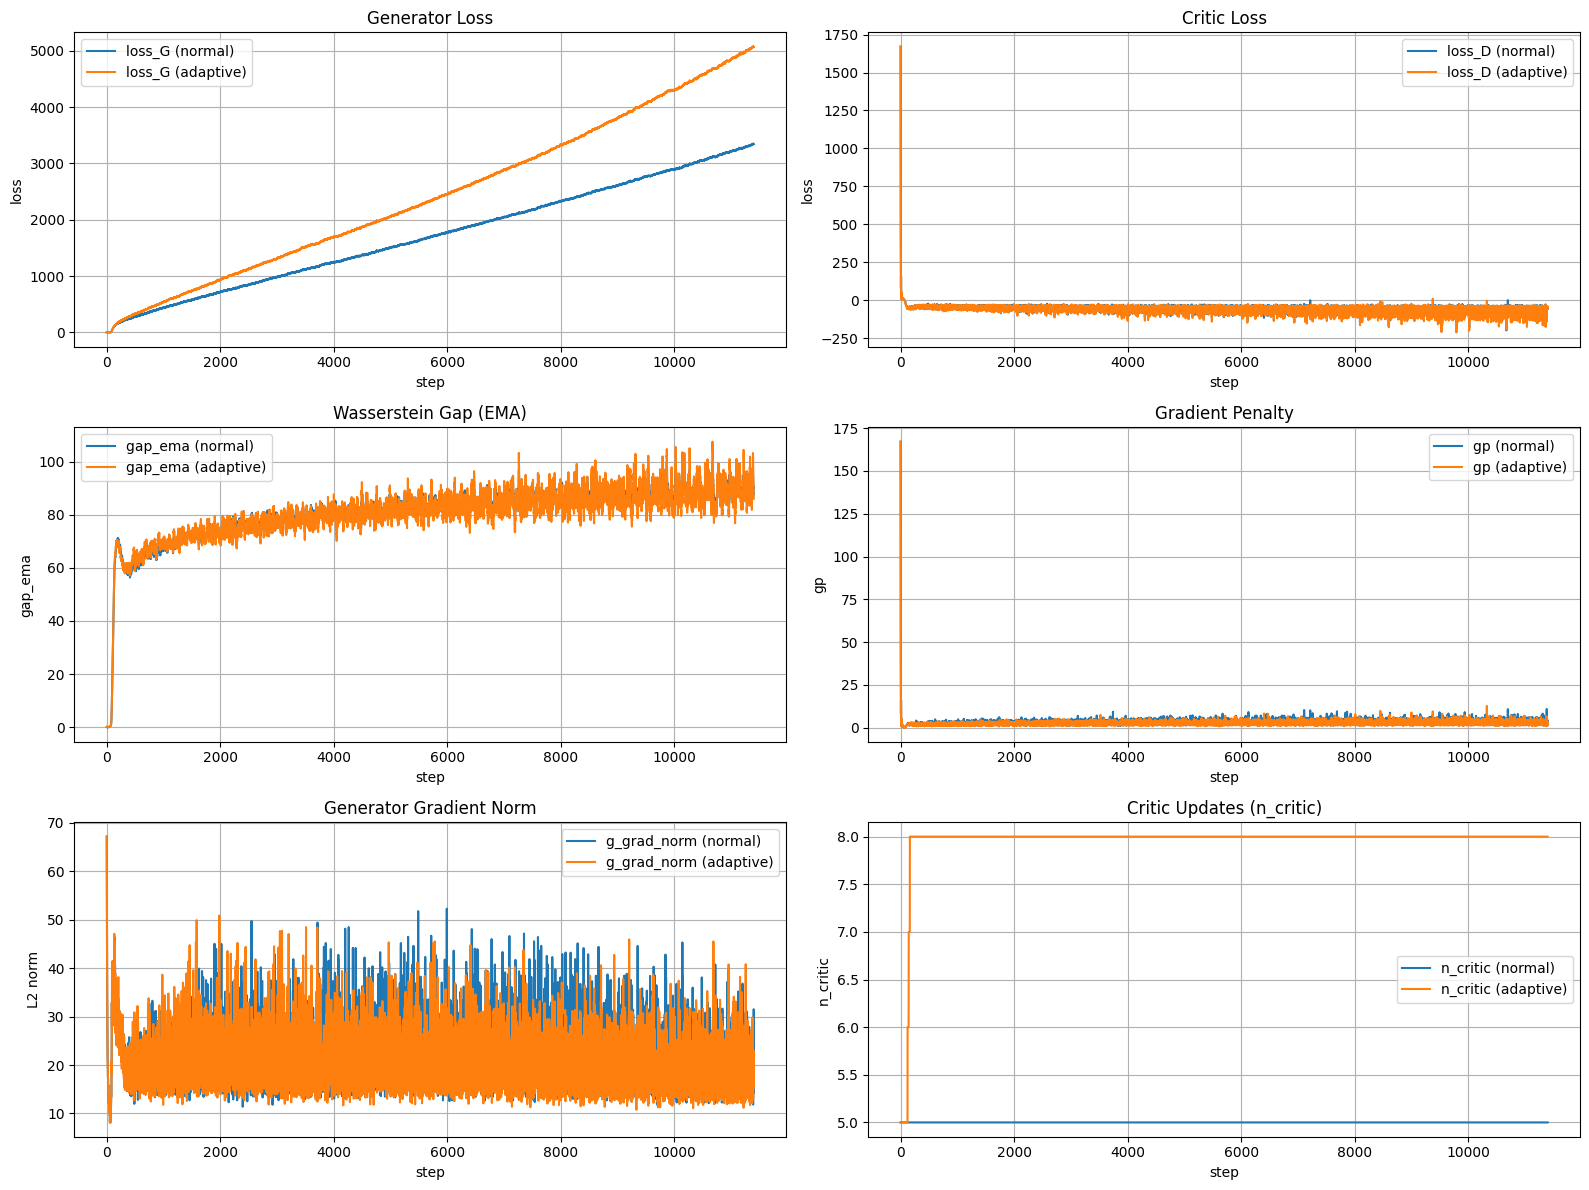

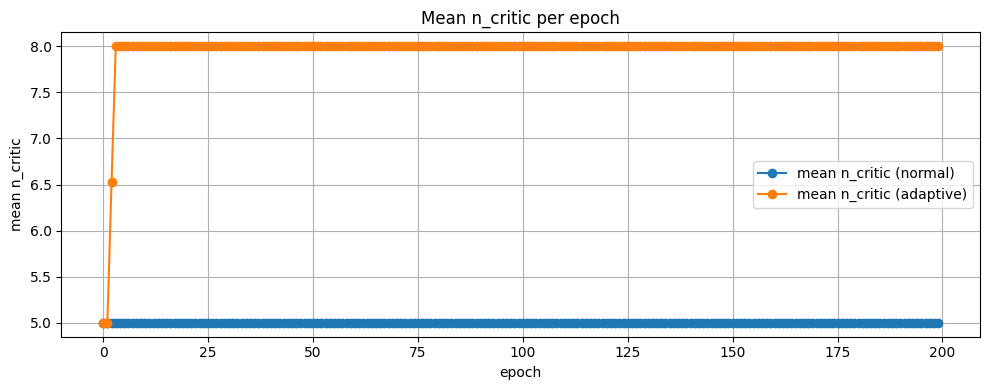

In [16]:
plot_compare(history_normal, history_adapt)